#### Importing Python libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_ind
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Reading in data file:

In [2]:
olympics_df = pd.read_excel('/Users/joshuakong/Documents/DS_Projects/olympics_medal_predictor/data/Olympics Data Set take home.xlsx')

#### Data dictionary:

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**id**|*integer*|olympics data|Unique identifier for athlete| 
|**sex**|*object*|olympics data|Gender|

## EDA, Cleaning, Transforming

#### Reviewing snippet of dataframe to gain familiarity with fields and values

In [3]:
olympics_df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


#### Descriptive analytics to further understand data, trends, and spread

In [4]:
olympics_df.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


#### Ensuring data types are correct

In [5]:
olympics_df.dtypes

ID          int64
Name       object
Sex        object
Age       float64
Height    float64
Weight    float64
Team       object
NOC        object
Games      object
Year        int64
Season     object
City       object
Sport      object
Event      object
Medal      object
dtype: object

#### Lowercasing all column names for convenience and convention

In [6]:
olympics_df.columns = [column.lower() for column in olympics_df.columns]

#### Replacing NaNs in medal field with string 'No'

In [7]:
olympics_df['medal'].replace(np.NaN, 'No', inplace=True)

#### Creating binary fields for gold, silver, bronze, and no medals

In [8]:
olympics_df['gold'] = [1 if medal == 'Gold' else 0 for medal in olympics_df['medal']]
olympics_df['silver'] = [1 if medal == 'Silver' else 0 for medal in olympics_df['medal']]
olympics_df['bronze'] = [1 if medal == 'Bronze' else 0 for medal in olympics_df['medal']]
olympics_df['no_medal'] = [1 if medal == 'No' else 0 for medal in olympics_df['medal']]

#### Check to ensure fields created in cell above were computed correctly

In [9]:
olympics_df[(olympics_df['medal'] == 'Bronze')][['medal','bronze']]

,medal,bronze
37,Bronze,1
38,Bronze,1
40,Bronze,1
41,Bronze,1
50,Bronze,1
...,...,...
271032,Bronze,1
271048,Bronze,1
271080,Bronze,1
271082,Bronze,1


#### Heatmap to visually see correlation between fields

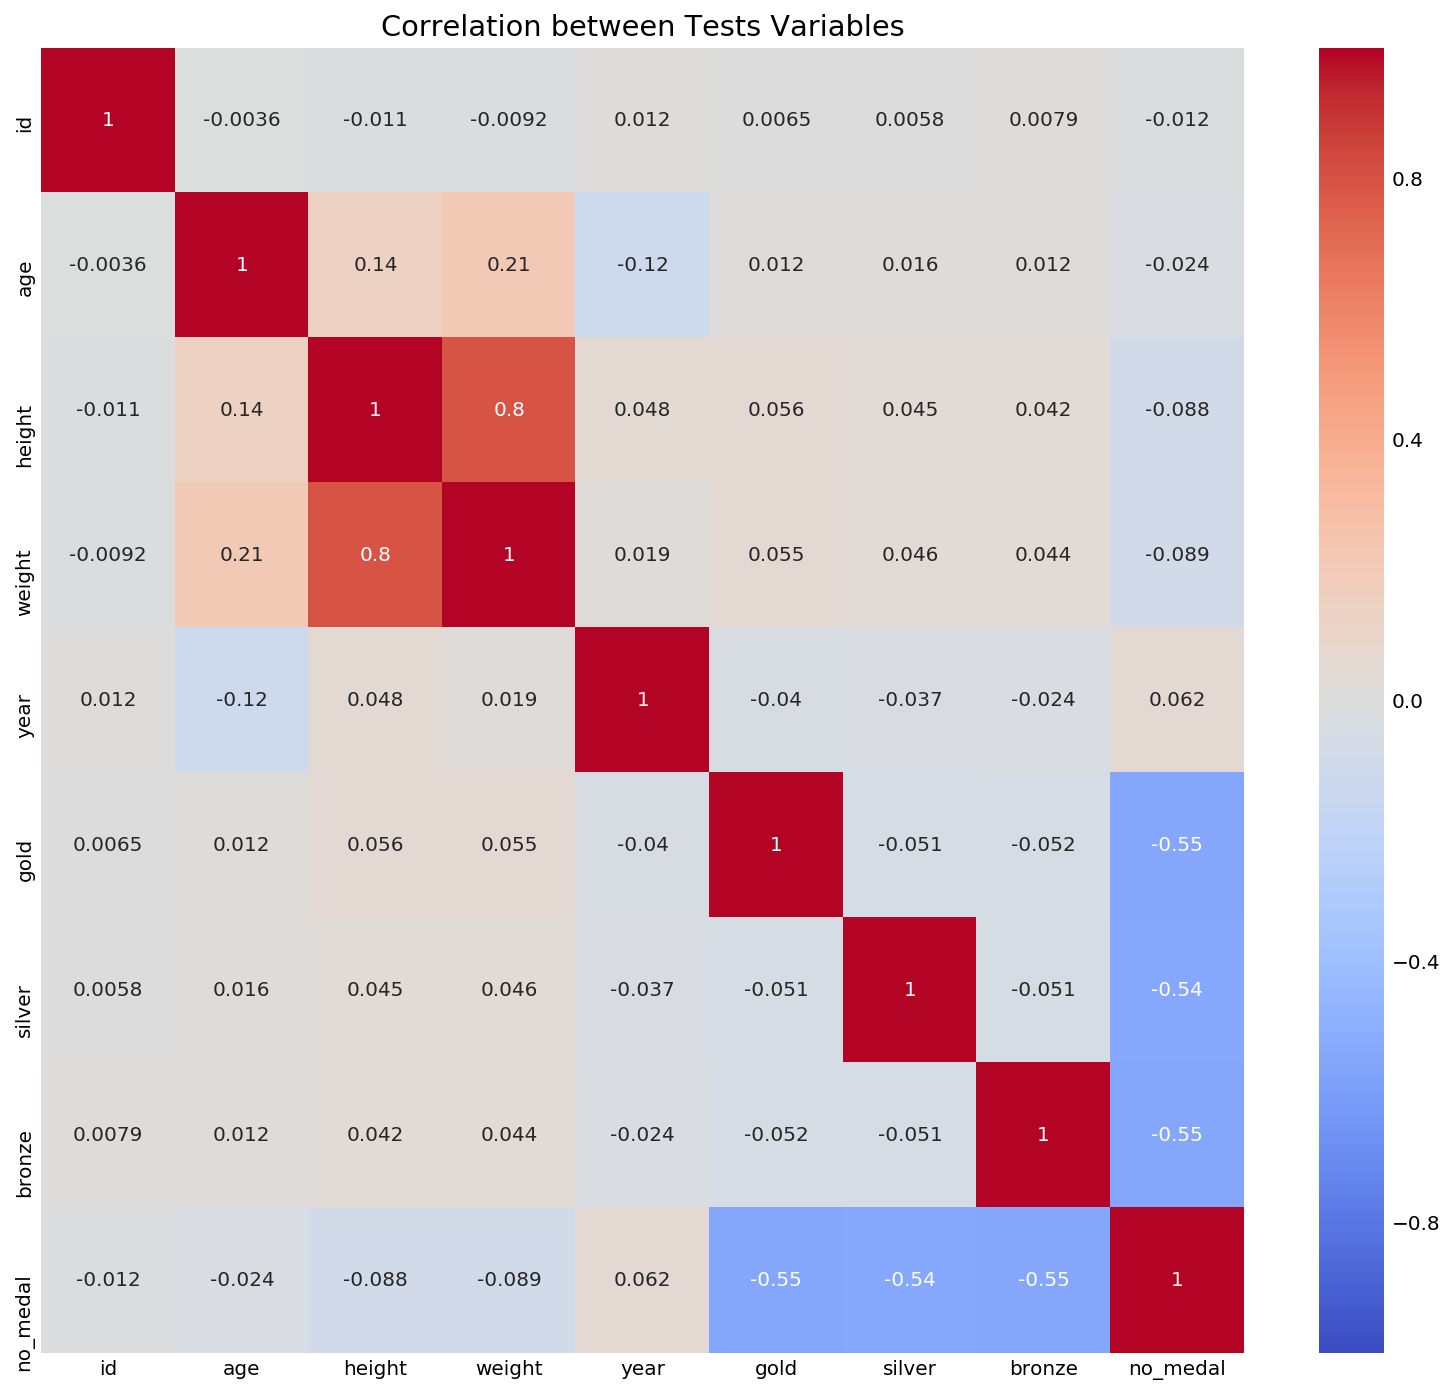

In [10]:
plt.figure(figsize=(12, 12))
sns.heatmap(olympics_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Tests Variables');

#### Summary of total null values per field

In [11]:
olympics_df.isnull().sum()

id              0
name            0
sex             0
age          9474
height      60171
weight      62875
team            0
noc             0
games           0
year            0
season          0
city            0
sport           0
event           0
medal           0
gold            0
silver          0
bronze          0
no_medal        0
dtype: int64

#### Dimensions of dataframe

In [12]:
olympics_df.shape

(271116, 19)

#### Replacing NaNs in age, height, & weight fields with mean for each field

In [13]:
olympics_df['age'].replace(np.NaN, olympics_df['age'].mean(), inplace=True)
olympics_df['height'].replace(np.NaN, olympics_df['height'].mean(), inplace=True)
olympics_df['weight'].replace(np.NaN, olympics_df['weight'].mean(), inplace=True)

#### Calling index with all column names to determine which features to dummy in cell below

In [14]:
olympics_df.columns

Index(['id', 'name', 'sex', 'age', 'height', 'weight', 'team', 'noc', 'games',
       'year', 'season', 'city', 'sport', 'event', 'medal', 'gold', 'silver',
       'bronze', 'no_medal'],
      dtype='object')

#### Quantifying select qualitative fields

In [15]:
olympics_df = pd.get_dummies(olympics_df, prefix=['sex','noc','games','season','city','sport'], 
                             columns=['sex','noc','games','season','city','sport'],drop_first=True)

#### Calling index with all quantitative fields

In [16]:
olympics_df.describe().columns

Index(['id', 'age', 'height', 'weight', 'year', 'gold', 'silver', 'bronze',
       'no_medal', 'sex_M',
       ...
       'sport_Table Tennis', 'sport_Taekwondo', 'sport_Tennis',
       'sport_Trampolining', 'sport_Triathlon', 'sport_Tug-Of-War',
       'sport_Volleyball', 'sport_Water Polo', 'sport_Weightlifting',
       'sport_Wrestling'],
      dtype='object', length=396)

#### Making index above a list to remove target (gold) from features

In [17]:
features = list(olympics_df.describe().columns)

In [18]:
features.remove('gold')

## Modeling

In [19]:
X = olympics_df[features]
y = olympics_df['gold']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size= 0.33,
                                                   random_state=42)


### Logistic Regression

In [20]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
print(f'Logistic Regression Train Accuracy Score: {logreg.score(X_train, y_train)}')
print(f'Logistic Regression Test Accuracy Score: {logreg.score(X_test, y_test)}')

Logistic Regression Train Accuracy Score: 0.9505304243945675
Logistic Regression Test Accuracy Score: 0.950977433524461


#### Predicting target (gold medal) using features from train and test data

In [21]:
y_preds_train = logreg.predict(X_train)
y_preds_test = logreg.predict(X_test)

In [22]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_preds_test[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

IndexError: too many indices for array

In [ ]:
from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(y_test, y_preds_test[:,1])

print(auc_score1, auc_score2)

#### Determining unique values of actual target 

In [23]:
print(y_test.unique())
print(y_train.unique())

[0 1]
[0 1]


#### Determining unique values of predicted target 

How to get unique values for array:
https://www.geeksforgeeks.org/python-get-unique-values-list/#:~:text=Using%20Python's%20import%20numpy%2C%20the,unique%20values%20from%20the%20list.

In [24]:
def unique(list1):
    x = np.array(list1)
    print(np.unique(x))

In [25]:
print("the unique values from y test predictions is")
unique(y_preds_test)

print("\nthe unique values from y train predictions is")
unique(y_preds_train)

the unique values from y test predictions is
[0]

the unique values from y train predictions is
[0]


In [26]:
set(y_test) - set(y_preds_test)

{1}

referenced https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi solution for f1 score warning

"decide that you are not interested in the scores of labels that were not predicted, and then explicitly specify the labels you are interested in (which are labels that were predicted at least once)"

In [27]:
train_f1 = metrics.f1_score(y_train, y_preds_train, labels=np.unique(y_preds_train))
test_f1 = metrics.f1_score(y_test, y_preds_test, labels=np.unique(y_preds_test))
print(f'train:{train_f1}, test:{test_f1}')

train:0.0, test:0.0


/Users/joshuakong/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# tn, fp  positive = medal winner
# fn, tp  negative = not medal winner
confusion_matrix(y_test, # True values.
                 y_preds_test)  # Predicted values.

array([[85083,     0],
       [ 4386,     0]])

### Decision Tree

In [29]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [30]:
print(dt.score(X_train, y_train))
dt.score(X_test, y_test)

1.0


1.0

In [31]:
y_preds_train = dt.predict(X_train)
y_preds_test = dt.predict(X_test)

In [32]:
train_f1 = metrics.f1_score(y_train, y_preds_train)
test_f1 = metrics.f1_score(y_test, y_preds_test)
print(f'train:{train_f1}, test:{test_f1}')

train:1.0, test:1.0


In [33]:
# tn, fp  positive = medal winner
# fn, tp  negative = not medal winner
confusion_matrix(y_test, # True values.
                 y_preds_test)  # Predicted values.

array([[85083,     0],
       [    0,  4386]])

### BDT

In [34]:
bag = BaggingClassifier(random_state=42)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)

In [35]:
print(bag.score(X_train, y_train))
bag.score(X_test, y_test)

1.0


1.0

In [36]:
y_preds_train = bag.predict(X_train)
y_preds_test = bag.predict(X_test)

In [37]:
train_f1 = metrics.f1_score(y_train, y_preds_train)
test_f1 = metrics.f1_score(y_test, y_preds_test)
print(f'train:{train_f1}, test:{test_f1}')

train:1.0, test:1.0


In [38]:
# tn, fp  positive = medal winner
# fn, tp  negative = not medal winner
confusion_matrix(y_test, # True values.
                 y_preds_test)  # Predicted values.

array([[85083,     0],
       [    0,  4386]])

### RF

In [39]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

/Users/joshuakong/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
cross_val_score(rf, X_train, y_train, cv=5).mean()

0.996702404456005

In [41]:
y_preds_train = rf.predict(X_train)
y_preds_test = rf.predict(X_test)

In [42]:
train_f1 = metrics.f1_score(y_train, y_preds_train)
test_f1 = metrics.f1_score(y_test, y_preds_test)
print(f'train:{train_f1}, test:{test_f1}')

train:0.9990531885268727, test:0.9596115124955585


In [43]:
# tn, fp  positive = medal winner
# fn, tp  negative = not medal winner
confusion_matrix(y_test, # True values.
                 y_preds_test)  # Predicted values.

array([[85077,     6],
       [  335,  4051]])

## These models to be evaluated at later time

### KNN

In [ ]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X_train_sc, y_train)

In [ ]:
print(knn.score(X_train_sc, y_train))
print(knn.score(X_test_sc, y_test))
cross_val_score(knn, X_train_sc, y_train, cv=5).mean()

In [ ]:
y_preds_train = knn.predict(X_train_sc)
y_preds_test = knn.predict(X_test_sc)

In [ ]:
train_f1 = metrics.f1_score(y_train, y_preds_train)
test_f1 = metrics.f1_score(y_test, y_preds_test)
print(f'train:{train_f1}, test:{test_f1}')

In [ ]:
# tn, fp  positive = medal winner
# fn, tp  negative = not medal winner
confusion_matrix(y_test, # True values.
                 y_preds_test)  # Predicted values.

### AdaBoost

In [ ]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [50,100],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.9, 1.]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3)
gs.fit(X_train, y_train)
gs.best_params_

In [ ]:
print(gs.best_score_)

In [ ]:
y_preds_train = gs.predict(X_train)
y_preds_test = gs.predict(X_test)

In [ ]:
train_f1 = metrics.f1_score(y_train, y_preds_train)
test_f1 = metrics.f1_score(y_test, y_preds_test)
print(f'train:{train_f1}, test:{test_f1}')

In [ ]:
# tn, fp  positive = medal winner
# fn, tp  negative = not medal winner
confusion_matrix(y_test, # True values.
                 y_preds_test)  # Predicted values.

### SVC

In [ ]:
svc = SVC(gamma='scale',random_state=42)
svc.fit(X_train, y_train)

In [ ]:
print(svc.score(X_train, y_train))
svc.score(X_test, y_test)

In [ ]:
y_preds_train = svc.predict(X_train)
y_preds_test = svc.predict(X_test)

In [ ]:
train_f1 = metrics.f1_score(y_train, y_preds_train)
test_f1 = metrics.f1_score(y_test, y_preds_test)
print(f'train:{train_f1}, test:{test_f1}')

In [ ]:
# tn, fp  positive = medal winner
# fn, tp  negative = not medal winner
confusion_matrix(y_test, # True values.
                 y_preds_test)  # Predicted values.